## Preprocesamiento del dataset de acciones de Tesla

In [5]:
import pandas as pd
import yfinance as yf
from langdetect import detect
import preprocessor as p
import string
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
import seaborn as sns

### Overview


Por la naturaleza de algunos de los indicadores en la parte de feature engineering no se puede obtener datos para los primeros 14 días en muchas columnas. Por ello, se amplia el dataset para poder obtener dichos valores. ras realizar las operaciones oportunas, se eliminarán las filas que no entren en el rango de fechas de los tweets (10/4 - 10/11).

In [6]:
df_stocks = pd.DataFrame(yf.download('TSLA','2022-03-10','2022-12-12'))
df_stocks.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-10,283.816681,284.816681,270.119995,279.433319,279.433319,58648500
2022-03-11,280.066681,281.266663,264.589996,265.116669,265.116669,67037100
2022-03-14,260.203339,266.899994,252.013336,255.456665,255.456665,71152200
2022-03-15,258.423340,268.523346,252.190002,267.296661,267.296661,66841200
2022-03-16,269.666656,280.666656,267.420013,280.076660,280.076660,84028800


In [7]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191 entries, 2022-03-10 to 2022-12-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       191 non-null    float64
 1   High       191 non-null    float64
 2   Low        191 non-null    float64
 3   Close      191 non-null    float64
 4   Adj Close  191 non-null    float64
 5   Volume     191 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 10.4 KB


In [8]:
df_stocks.drop(['Adj Close'], axis=1, inplace=True)

Como fue notado en los scripts de caracterización de los datos, la columna Adj Close y Close son idénticas, por lo que se elimina del dataframe.

## Feature Engineering

In [9]:
df_stocks['Daily_Return'] = df_stocks['Close'].pct_change()
df_stocks['Moving_Average'] = df_stocks['Close'].rolling(window=14).mean()
df_stocks['Open_Close_Range'] = df_stocks['Close'] - df_stocks['Open']

In [10]:
#Calculo oscilador Estocástico

period = 14

df_stocks['Lowest_Low'] = df_stocks['Low'].rolling(window=period).min()
df_stocks['Highest_High'] = df_stocks['High'].rolling(window=period).max()
df_stocks['%K'] = ((df_stocks['Close'] - df_stocks['Lowest_Low']) / (df_stocks['Highest_High'] - df_stocks['Lowest_Low'])) * 100

smoothing_period = 3  
df_stocks['%D'] = df_stocks['%K'].rolling(window=smoothing_period).mean()

In [11]:
#Calculo RSI

period = 14

delta = df_stocks['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=period).mean()
avg_loss = loss.rolling(window=period).mean()


rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

df_stocks['RSI'] = rsi

df_stocks.sample(5)


,Open,High,Low,Close,Volume,Daily_Return,Moving_Average,Open_Close_Range,Lowest_Low,Highest_High,%K,%D,RSI
Date,,,,,,,,,,,,,
2022-11-02,226.039993,227.869995,214.820007,214.979996,63070300,-0.056360,219.325000,-11.059998,198.589996,237.399994,42.231385,66.581554,46.266340
2022-06-29,230.500000,231.173340,222.273331,228.490005,82897200,-0.017937,230.814048,-2.009995,208.693329,255.546661,42.252441,56.910464,44.285918
2022-10-31,226.190002,229.850006,221.940002,227.539993,61554300,-0.004289,219.050715,1.349991,198.589996,233.809998,82.197603,80.806362,56.702279
2022-08-26,297.429993,302.000000,287.470001,288.089996,57163900,-0.026953,296.527858,-9.339996,279.353333,314.666656,24.740418,40.774681,48.613196
2022-08-01,301.276672,311.876678,295.000000,297.276672,117042900,0.000426,262.170474,-4.000000,225.033340,311.876678,83.188110,92.490879,85.288707


In [12]:
# Calculo MFI

df_stocks['Typical_Price'] = (df_stocks['High'] + df_stocks['Low'] + df_stocks['Close']) / 3
df_stocks['Raw_Money_Flow'] = df_stocks['Typical_Price'] * df_stocks['Volume']
rmf = df_stocks['Typical_Price'] * df_stocks['Volume']

pmf = rmf.where(df_stocks['Typical_Price'] > df_stocks['Typical_Price'].shift(1), 0)
nmf = rmf.where(df_stocks['Typical_Price'] < df_stocks['Typical_Price'].shift(1), 0)

rmr = pmf.rolling(window=14).sum() / nmf.rolling(window=14).sum()

df_stocks['MFI'] = 100 - (100 / (1 + rmr))

<AxesSubplot: >

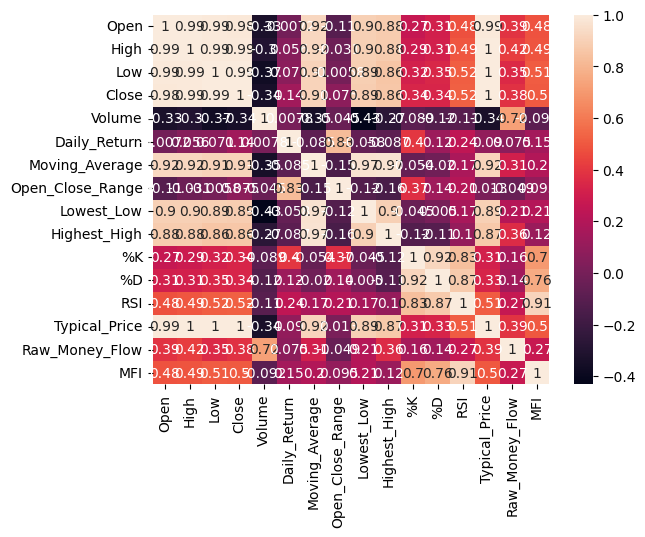

In [13]:
corr_matrix = df_stocks.corr()
sns.heatmap(corr_matrix, annot=True)

In [14]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191 entries, 2022-03-10 to 2022-12-09
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              191 non-null    float64
 1   High              191 non-null    float64
 2   Low               191 non-null    float64
 3   Close             191 non-null    float64
 4   Volume            191 non-null    int64  
 5   Daily_Return      190 non-null    float64
 6   Moving_Average    178 non-null    float64
 7   Open_Close_Range  191 non-null    float64
 8   Lowest_Low        178 non-null    float64
 9   Highest_High      178 non-null    float64
 10  %K                178 non-null    float64
 11  %D                176 non-null    float64
 12  RSI               178 non-null    float64
 13  Typical_Price     191 non-null    float64
 14  Raw_Money_Flow    191 non-null    float64
 15  MFI               178 non-null    float64
dtypes: float64(15), int64(1)


### Normalización

Se utiliza MinMaxScaler para normalizar las columnas de dataset entre -1 y 1. Se comprueba que la normalización se ha realizado correctamente.

Apunte: La normalización de las fechas se hace a mano, ya que el formato datetime no es admitido por la función de MinMaxScaler.

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))

for column in df_stocks.columns:
    if column != 'Date':
        df_stocks[column] = scaler.fit_transform(df_stocks[column].values.reshape(-1, 1))


df_stocks.sample(5)

,Open,High,Low,Close,Volume,Daily_Return,Moving_Average,Open_Close_Range,Lowest_Low,Highest_High,%K,%D,RSI,Typical_Price,Raw_Money_Flow,MFI
Date,,,,,,,,,,,,,,,,
2022-05-18,0.378531,0.387027,0.343519,0.321264,0.445619,0.245065,0.522588,0.460681,0.381099,0.645088,0.104648,0.177055,0.233894,0.351987,0.368329,0.276658
2022-04-13,0.753779,0.802175,0.806023,0.808239,0.128567,0.718108,0.996981,0.876004,0.996765,1.000000,0.273609,0.099085,0.455080,0.812554,0.285589,0.611041
2022-09-27,0.548262,0.551858,0.567255,0.537844,0.194557,0.669027,0.664223,0.635609,0.656122,0.619733,0.290253,0.197186,0.436960,0.555709,0.255315,0.537373
2022-03-23,0.751971,0.824764,0.811629,0.771999,0.764355,0.578214,NaN,0.755123,NaN,NaN,NaN,NaN,NaN,0.809576,0.963674,NaN
2022-06-27,0.384210,0.380325,0.389194,0.360136,0.458872,0.540140,0.295628,0.577463,0.267839,0.305479,0.782033,0.742755,0.483004,0.377734,0.393084,0.682478


In [16]:
df_stocks.reset_index(inplace=True)

mask1 = df_stocks['Date'] < pd.to_datetime('2022-11-12')
mask2 = df_stocks['Date'] > pd.to_datetime('2022-04-10')

df_stocks = df_stocks[mask1]
df_stocks = df_stocks[mask2]

print(len(df_stocks.columns))
df_stocks.isnull().sum()

17


C:\Users\34644\AppData\Local\Temp\ipykernel_8068\1974532868.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_stocks = df_stocks[mask2]


Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
Daily_Return        0
Moving_Average      0
Open_Close_Range    0
Lowest_Low          0
Highest_High        0
%K                  0
%D                  0
RSI                 0
Typical_Price       0
Raw_Money_Flow      0
MFI                 0
dtype: int64

In [17]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(df_stocks.drop(['Date'], axis=1))
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7','PC8', 'PC9', 'PC10'])

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance_ratio)

Explained Variance Ratios: [0.42925599 0.36104452 0.0914887  0.06793445 0.02800293 0.00784518
 0.0058579  0.00338533 0.00274676 0.00132429]
